# Tropospheric corrections using GACOS
**Author**: Bekaert David, Simran Sangha - Jet Propulsion Laboratory

Updated by Ann Chen 2025

In this notebook, we will walk through the steps in order to correct a geo-coded interferogram with GACOS. 
We will apply the corrections to a topsApp geo-coded Sentinel-1 interferogram of the 12 November 2017 Mw7.3 earthquake that occurred in Iran.

![title](support_docs/region.png)

## 0. Initial set-up for the notebook

We will start with the initial set-up of the notebook. This step only needs to be run at the very beginning and defines the processing locations as well as a few plotting routines that will be used throughout the tutorial.

In [21]:
# option to control the use of pre-staged data; [False/True]
Use_Staged_Data = True

# ------------------------------------------------------------------------------------------- #
# no changes below needed:

from shutil import copyfile
from osgeo import gdal            ## GDAL support for reading virtual files
import os                         ## To create and remove directories
import matplotlib.pyplot as plt   ## For plotting
import numpy as np                ## Matrix calculations
import glob                       ## Retrieving list of files
import isce 

## Defining the home directory as an absolute path
if 'tutorial_home_dir' in locals(): 
    print(tutorial_home_dir)
    pass
else:
    # define local paths
    tutorial_home_dir = os.getcwd()
print(tutorial_home_dir) 
## If specified, prep and use staged data
if Use_Staged_Data:
    # Check if a stage file from S3 already exist, if not try and download it
    if not os.path.isfile('tropo.zip'):
        !aws s3 cp --region us-east-1 --no-sign-request s3://asf-jupyter-data-west/unavco2021/tropo.zip tropo.zip

    # verify if download was succesful
    if os.path.isfile('tropo.zip'):
        if os.path.isdir('tropoStageData'):
            !rm -rf tropoStageData
        !unzip tropo.zip
        print('S3 pre-staged data retrieval was successful')
    else:
        print("Download outside openSarLabs is not supported.")
    # define local paths
else:
    print("Will not be using S3 pre-staged data")


print("home directory: ", tutorial_home_dir)
processing_dir = os.path.join(tutorial_home_dir,'insar','merged')
processing_slc_dir = os.path.join(tutorial_home_dir,'slc')
if not os.path.isdir(tutorial_home_dir):
    os.makedirs(tutorial_home_dir)
if not os.path.isdir(processing_slc_dir):
    os.makedirs(processing_slc_dir)
os.chdir(tutorial_home_dir)

# define gacos path
gacos_dir  =  os.path.join(tutorial_home_dir,'gacos_download')
# generate all the folders in case they do not exist yet
if not os.path.isdir(gacos_dir):
    os.makedirs(gacos_dir)
if not os.path.isdir(processing_dir):
    os.makedirs(processing_dir)
    
# defining backup dirs in case of download issues on the local server
data_backup_dir = os.path.abspath(os.path.join(tutorial_home_dir,"tropoStageData"))
gacos_backup_dir = os.path.join(data_backup_dir,'gacos_backup')
processing_backup_dir  =  os.path.join(data_backup_dir,'insar','merged')
processing_slc_backup_dir  =  os.path.join(data_backup_dir,'slc')
    
# copy in the InSAR data 
cmd = "cp -r " + os.path.join(processing_backup_dir,'*') + " " + os.path.join(processing_dir,'.')
os.system(cmd)
cmd = "cp -r " + os.path.join(processing_slc_backup_dir,'*') + " " + os.path.join(processing_slc_dir,'.')
os.system(cmd)



def plotdata(GDALfilename,band=1,title=None,colormap='gray',aspect=1, datamin=None, datamax=None,draw_colorbar=True,colorbar_orientation="horizontal",background=None):
    ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
    data = ds.GetRasterBand(band).ReadAsArray()
    transform = ds.GetGeoTransform()
    ds = None
    
    # getting the min max of the axes
    firstx = transform[0]
    firsty = transform[3]
    deltay = transform[5]
    deltax = transform[1]
    lastx = firstx+data.shape[1]*deltax
    lasty = firsty+data.shape[0]*deltay
    ymin = np.min([lasty,firsty])
    ymax = np.max([lasty,firsty])
    xmin = np.min([lastx,firstx])
    xmax = np.max([lastx,firstx])

    # put all zero values to nan and do not plot nan
    if background is None:
        try:
            data[data==0]=np.nan
        except:
            pass

    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111)
    cax = ax.imshow(data, vmin = datamin, vmax=datamax, cmap=colormap,extent=[xmin,xmax,ymin,ymax])
    ax.set_title(title)
    if draw_colorbar is not None:
        cbar = fig.colorbar(cax,orientation=colorbar_orientation)
    ax.set_aspect(aspect)    
    plt.show()
    data = None

def plotdata2(GDALfilename1,GDALfilename2,band=1,title=None,colormap='gray',aspect=1, datamin=None, datamax=None,draw_colorbar=True,background=None,plot_profile=None):
   
    # profiles to be drawn if requested
    profiles_x = [1100,600]
    profiles_y = [1600,600]


    # plotting a two pannel dataset
    counter=1
    GDALfilenames = [GDALfilename1,GDALfilename2]
    fig = plt.figure(figsize=(9, 8))
    for GDALfilename in GDALfilenames:
        ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
        data = ds.GetRasterBand(band).ReadAsArray()
        transform = ds.GetGeoTransform()
        ds = None

        # getting the min max of the axes
        firstx = transform[0]
        firsty = transform[3]
        deltay = transform[5]
        deltax = transform[1]
        lastx = firstx+data.shape[1]*deltax
        lasty = firsty+data.shape[0]*deltay
        ymin = np.min([lasty,firsty])
        ymax = np.max([lasty,firsty])
        xmin = np.min([lastx,firstx])
        xmax = np.max([lastx,firstx])

        ax = fig.add_subplot(1,2,counter)
        
        # put all zero values to nan and do not plot nan
        if background is None:
            try:
                data[data==0]=np.nan
            except:
                pass

        cax = ax.imshow(data, vmin = datamin, vmax=datamax, cmap=colormap,extent=[xmin,xmax,ymin,ymax])
         

        # in case a profile is requested to be plotted, then show it on the overview figure and compute the profile
        if plot_profile is not None:
            if counter==1:
                data1=[]
                linetype='-'
                linecolor='magenta'
                for profile_x in profiles_x:
                    data1.append(data[0:-1,profile_x])  
                for profile_y in profiles_y:
                    data1.append(data[profile_y,0:-1])
            elif counter==2:
                data2=[]
                linetype='--'
                linecolor='k'
                for profile_x in profiles_x:
                    data2.append(data[0:-1,profile_x])  
                for profile_y in profiles_y:
                    data2.append(data[profile_y,0:-1])

            # plot the profiles on the figure
            count_profile_total=0
            for profile_y in profiles_y:
                profile_lat = firsty+profile_y*deltay
                ax.plot([xmin, xmax],[profile_lat, profile_lat],linestyle=linetype, color=linecolor)
                count_profile_total +=1
                ax.text(np.mean([xmin,xmax]),profile_lat,str(count_profile_total),fontsize=20)
            for profile_x in profiles_x:
                profile_lon = firstx+profile_x*deltax
                ax.plot([profile_lon, profile_lon],[ymin,ymax],linestyle=linetype, color=linecolor)
                count_profile_total +=1
                ax.text(profile_lon,np.mean([ymin,ymax]),str(count_profile_total),fontsize=20)

        
        ax.set_title(title[counter-1])
        if draw_colorbar is not None:
            cbar = fig.colorbar(cax,orientation="horizontal")
        ax.set_aspect(aspect)
        counter +=1
    plt.show()
    
    # plotting the profile if requested
    if plot_profile is not None:
        fig2 = plt.figure(figsize=(15, 14))
        for i_profile in range(count_profile_total):
            ax = fig2.add_subplot(count_profile_total,1,i_profile+1)
            ax.plot(range(len(data2[i_profile])),data2[i_profile],'--',color='k')
            ax.plot(range(len(data1[i_profile])),data1[i_profile],'-',color='magenta')
            ax.set_title('profile number ' + str(i_profile+1))
        plt.show()
        
    data = None

/home/jovyan/Troposphere
/home/jovyan/Troposphere
download: s3://asf-jupyter-data-west/unavco2021/tropo.zip to ./tropo.zip
Archive:  tropo.zip
   creating: tropoStageData/
   creating: tropoStageData/slc/
 extracting: tropoStageData/slc/S1A_IW_SLC__1SDV_20171111T150004_20171111T150032_019219_0208AF_EE89.zip  
 extracting: tropoStageData/slc/S1B_IW_SLC__1SDV_20171117T145900_20171117T145928_008323_00EBAB_B716.zip  
 extracting: tropoStageData/slc/S1B_IW_SLC__1SDV_20171117T145926_20171117T145953_008323_00EBAB_AFB8.zip  
   creating: tropoStageData/gacos_backup/
  inflating: tropoStageData/gacos_backup/20171111.ztd.rsc  
  inflating: tropoStageData/gacos_backup/20171117.ztd.jpg  
  inflating: tropoStageData/gacos_backup/20171111.ztd  
  inflating: tropoStageData/gacos_backup/20171111-20171117.dztd.jpg  
  inflating: tropoStageData/gacos_backup/20180628T013133.tar.gz  
  inflating: tropoStageData/gacos_backup/20171111-20171117.dztd  
  inflating: tropoStageData/gacos_backup/20171117.ztd  
 

## 1. Overview of the tutorial input dataset

The following steps require geocoded interferogram products that are compatible with gdal and have correct georeference information stored in their metadata. Geocoded **ISCE** product have a **.geo** suffix, while the addition of the **.vrt** suffix makes sure the products are also compatible with gdal. 

As part of this tutorial we use a Sentinel-1 dataset which has already been pre-processed with *topsApp.py*. You can find the unwrapped interferogram (*filt_topophase.flat.geo*) and the line-of-sight angles (*los.rdr.geo*), containing incidence and heading, in the **insar/merged** data folder.

In [22]:
!ls insar/merged

20171111.aps.geo	   20171117.ztd.geo	       los.rdr.geo.vrt
20171111.aps.hdr	   20171117.ztd.hdr	       los.rdr.geo.xml
20171111.ztd.geo	   filt_topophase_aps.unw.geo  phsig.cor.geo
20171111.ztd.hdr	   filt_topophase_aps.unw.hdr  phsig.cor.geo.vrt
20171117_20171111.aps.geo  filt_topophase.unw.geo      phsig.cor.geo.xml
20171117_20171111.aps.hdr  filt_topophase.unw.geo.vrt  topsApp.xml
20171117.aps.geo	   filt_topophase.unw.geo.xml  tropoStageData
20171117.aps.hdr	   los.rdr.geo		       tropo.zip


To verify that your *FILE* is gdal compatible try to run:
```
    gdalinfo FILE
```
Verify the coordinate information to ensure the parsing from the metadata is done correctly. This can be done by investigating the output from gdalinfo: 
- Coordinate System: typically reports an EPSG code, or spells out the coodinate system in its complete such as WGS84.
- Origin: the origin of the coordinate system
- Pixel Size: the sampling/resolution of the data
- Corner Coordinates: longitude and latitude corners of the data

In [23]:
!gdalinfo insar/merged/filt_topophase.unw.geo.vrt

Driver: VRT/Virtual Raster
Files: insar/merged/filt_topophase.unw.geo.vrt
       insar/merged/filt_topophase.unw.geo
Size is 1574, 2017
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
           

The names of the original input SLC's used in the processing are containted in the **SLC** folder. By exploring the SLC folder, you can see that these products files are zip archives. When unpacked the zip extension will be replaced by SAFE. The products are therefore also frequently called SAFE files. The SAFE filenames provide information on the product type, the polarization, the start and stop acquisition time. For example: S1A_IW_SLC__1SDV_20171111T150004_20171111T150032_019219_0208AF_EE89.zip 
- Type = slc
- Polarization = Dual pole 
- Date = 20171111
- UTC time of acquisition = ~15:00
- Sensing start for the acquisition was 20171111 at 15:00:04


## 2. Overview of the GACOS dataset

### 2.1 Background on GACOS

The Generic Atmospheric Correction Online Service for InSAR (GACOS) allows for the on-demand generation of zenith tropospheric delay maps given a user specified region of interest, date, and UTC time. Currently no command line API exist, but orders can be submitted using the online form at: http://www.gacos.net/

### 2.2 GACOS download

Let us first find all the required information needed to complete online GACOS fields 

#### 2.2.1 Dates and UTC 

- **Dates** and **UTC**: For sentinel-1, the date and UTC information can be directly extracted from the original SAFE filename. For example: S1A_IW_SLC__1SDV_20171111T150004_20171111T150032_019219_0208AF_EE89 corresponds to an acquisition made on 20171111 at ~15:00 UTC. 

What are the other dates and do they roughly have the same acquisition time?

In [24]:
!grep slc insar/merged/topsApp.xml

      <property name="safe">['../../slc/S1B_IW_SLC__1SDV_20171117T145900_20171117T145928_008323_00EBAB_B716.zip','../../slc/S1B_IW_SLC__1SDV_20171117T145926_20171117T145953_008323_00EBAB_AFB8.zip']</property>
      <property name="safe">['../../slc/S1A_IW_SLC__1SDV_20171111T150004_20171111T150032_019219_0208AF_EE89.zip']</property>


#### 2.2.2 Region

- **Region**: You can extract the region information directly from the .geo.vrt file with gdalinfo. Look at the corner coordinates.

In [25]:
!gdalinfo insar/merged/filt_topophase.unw.geo.vrt

Driver: VRT/Virtual Raster
Files: insar/merged/filt_topophase.unw.geo.vrt
       insar/merged/filt_topophase.unw.geo
Size is 1574, 2017
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
           

#### 2.2.3 Summary of parameters

- dates: 20171111 and 20171117
- UTC: ~15:00 UTC (UTC does not vary much for SAR scenes acquired from the same path over the same area due to their typical sun synchronous dawn-dusk orbit)
- region: North=35.49, South=33.82, West=45.25, East=46.55
- data type: Geotiff

<div class="alert alert-warning">
<b>NOTE on REGION:</b> 
For ease we will select a region of integer degrees. **Region: North=36, South=33, West=45, East=47**
</div>

<div class="alert alert-danger">
<b>NOTE on Data type:</b>
GACOS supports both tiff and Binary grid formats. This notebook has pre-staged backup data in Binary Grid format. If executed in tiff format the first pre-processing step should be skipped. Additionally one should add suffix .tif to filenames.
</div>

#### 2.2.4 Placing GACOS order

Now that we have all the required parameters at hand, initiate the GACOS request online at http://www.gacos.net/. 
![title](support_docs/gacos_order.png)

An email will be send to you once the processing has completed, depending on the number of requests this could take a few minutes or much longer. The completion email contains an FTP URL where the product can be downloaded. 

For this tutorial we will download the GACOS product into a *gacos_download* processing folder. As we are processing this tutorial remotely, we will be using commandline **wget** for the download of the products. 
```
cd gacos_download
wget GACOS_FILE.tar.gz
```
We will use the command line **tar** functionality to unzip the file
```
tar -xvf GACOS_FILE.tar.gz
```

<div class="alert alert-warning">
<b>GACOS NOTES:</b> 
<br>
- The delays provided by GACOS are in meter units.
<br>
- Suffix *.ztd* refers to the zenith (vertical column) tropospheric delay, and *.dztd* refers to the differential *.ztd*. 
<br>
- The GACOS ReadMe.pdf contains more information on the definition and references.
</div>


**In case you are having issue with the download of the product proceed below, if not, skip directly to Section 3**

##### In case of unsuccessful download

In case you are unable to download the product, we have already downloaded it for this tutorial in the gacos folder. You can copy this folder content into the *gacos_download* folder

In [26]:
# copy in the GACOS data 
cmd = "cp -r " + os.path.join(gacos_backup_dir,'*') + " " + os.path.join(gacos_dir,'.')
os.system(cmd)
!ls gacos_download/*


gacos_download/20171111-20171117.dztd
gacos_download/20171111-20171117.dztd.jpg
gacos_download/20171111-20171117.dztd.rsc
gacos_download/20171111.ztd
gacos_download/20171111.ztd.hdr
gacos_download/20171111.ztd.jpg
gacos_download/20171111.ztd.rsc
gacos_download/20171117.ztd
gacos_download/20171117.ztd.hdr
gacos_download/20171117.ztd.jpg
gacos_download/20171117.ztd.rsc
gacos_download/20180628T013133.tar.gz
gacos_download/ReadMe.pdf


In [27]:
!ls gacos_download/*


gacos_download/20171111-20171117.dztd
gacos_download/20171111-20171117.dztd.jpg
gacos_download/20171111-20171117.dztd.rsc
gacos_download/20171111.ztd
gacos_download/20171111.ztd.hdr
gacos_download/20171111.ztd.jpg
gacos_download/20171111.ztd.rsc
gacos_download/20171117.ztd
gacos_download/20171117.ztd.hdr
gacos_download/20171117.ztd.jpg
gacos_download/20171117.ztd.rsc
gacos_download/20180628T013133.tar.gz
gacos_download/ReadMe.pdf


## 3. SAR Tropospheric phase delay (slant)

In this chapter we will convert the GACOS pseudo-range zenith tropospheric delays, into the projection reference as the geo-coded interferogram and project the zenith delay to the slant using the incidence angle information.
$$\Phi_{\text{slant}}=\frac{-4 \pi}{\lambda* cos(\theta)}*d_{\text{zenith}}$$

### 3.1 Creating ENVI header files¶

<div class="alert alert-danger">
GACOS  supports both tiff and Envi file formats. The pre-staged data is assuming ENVI format, which requires an additional pre-processing step. When selecting tiff, skip this step.
</div>

We will be using GDAL to interpolate the GACOS products on the same grid as our geocoded interferogram. The Binary grid format is not directly compatible with GDAL.

In [28]:
!gdalinfo gacos_download/20171111.ztd

Driver: ENVI/ENVI .hdr Labelled
Files: gacos_download/20171111.ztd
       gacos_download/20171111.ztd.hdr
Size is 2401, 3601
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ID["EPSG",6326]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["Degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["longitude",east,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["latitude",north,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]]
Data axis to CRS axis mapping: 1,2
Origin = (45.000000000000000,36.000000000000000)
Pixel Size = (0.000833330000000,-0.000833330000000)
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  45.0000000,  36.0000000) ( 45d 0' 0.00"E, 36d 0' 0.00"N)
Lower Left  (  45.0000000,  32.9991



This can be solved by making a new ENVI .hdr file. Below we include a function loadrsc which will open the GACOS .rsc file and load the relevant information. Another provided function will generate the .hdr file using a predefined template and the information extracted from the .rsc file. Execute the following cell to make these functions available for usage.


In [29]:
def loadrsc(infile):
    '''A function to load the content of .rsc file and pass it back as a dictionary'''
    import numpy as np
    with open(infile + '.rsc') as f:
        text = f.read()
    lines = [e.split() for e in text.split("\n") if e != ""]
    headers = dict(lines)
    # add the filename such it can be called when making envi header
    headers['FILENAME'] = infile
    # take the abs of the y-spacing as upper left corner is to be specified
    headers['Y_STEP'] = str(np.abs(float(headers['Y_STEP'])))
    return headers

def writehdr(filename,headers):
    '''A function that writes a .hdr file from a template and a dictionarydescribing the fields'''
    print('Writing output HDR file...')
    print(headers)
    enviHDRFile = open(filename + '.hdr', 'w')
    enviHDR = '''ENVI
description = {{GACOS: {FILENAME} }}
samples = {WIDTH}
lines = {FILE_LENGTH}
bands = 1
header offset = 0
file type = ENVI Standard
data type = 4
interleave = bsq
sensor type = Unknown
byte order = 0
map info = {{Geographic Lat/Lon, 1, 1, {X_FIRST}, {Y_FIRST}, {X_STEP}, {Y_STEP}, WGS-84, units=Degrees}}
coordinate system string = {{GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]]}}'''.format(**headers)

    enviHDRFile.write(enviHDR)
    enviHDRFile.close()
    print('Output HDR file =', filename)

def GACOS_rsc2hdr(inputfile):
    '''
    Wrapper code which calls .rsc reader and .hdr writer functionality 
    '''

    print('Generating hdr file for: ' + inputfile + '...')
    # make sure the user does not give a header file as input
    filename, file_extension = os.path.splitext(inputfile)
    if file_extension == '.hdr' or file_extension == '.rsc':
        raise Exception("Give path to the ENVI file not the .hdr or .rsc file")
    headers = loadrsc(inputfile)
    writehdr(inputfile,headers)
    print('hdr for ' + inputfile + ' generated')
    print(" ")

We will generate the header files for all the SAR delays files:

In [30]:
GACOS_rsc2hdr('gacos_download/20171111.ztd')
GACOS_rsc2hdr('gacos_download/20171117.ztd')

Generating hdr file for: gacos_download/20171111.ztd...
Writing output HDR file...
{'WIDTH': '2401', 'FILE_LENGTH': '3601', 'XMIN': '0', 'XMAX': '2401', 'YMIN': '0', 'YMAX': '3601', 'X_FIRST': '45.0000000', 'Y_FIRST': '36.0000000', 'X_STEP': '0.000833330000000', 'Y_STEP': '0.00083333', 'X_UNIT': 'degres', 'Y_UNIT': 'degres', 'Z_OFFSET': '0', 'Z_SCALE': '1', 'PROJECTION': 'LATLON', 'DATUM': 'WGS84', 'FILENAME': 'gacos_download/20171111.ztd'}
Output HDR file = gacos_download/20171111.ztd
hdr for gacos_download/20171111.ztd generated
 
Generating hdr file for: gacos_download/20171117.ztd...
Writing output HDR file...
{'WIDTH': '2401', 'FILE_LENGTH': '3601', 'XMIN': '0', 'XMAX': '2401', 'YMIN': '0', 'YMAX': '3601', 'X_FIRST': '45.0000000', 'Y_FIRST': '36.0000000', 'X_STEP': '0.000833330000000', 'Y_STEP': '0.00083333', 'X_UNIT': 'degres', 'Y_UNIT': 'degres', 'Z_OFFSET': '0', 'Z_SCALE': '1', 'PROJECTION': 'LATLON', 'DATUM': 'WGS84', 'FILENAME': 'gacos_download/20171117.ztd'}
Output HDR file 

Let us verify if the files are now GDAL compatible, and if the geo-reference information is correctly represented.

In [31]:
!gdalinfo gacos_download/20171117.ztd

Driver: ENVI/ENVI .hdr Labelled
Files: gacos_download/20171117.ztd
       gacos_download/20171117.ztd.hdr
Size is 2401, 3601
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ID["EPSG",6326]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["Degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["longitude",east,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["latitude",north,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]]
Data axis to CRS axis mapping: 1,2
Origin = (45.000000000000000,36.000000000000000)
Pixel Size = (0.000833330000000,-0.000833330000000)
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  45.0000000,  36.0000000) ( 45d 0' 0.00"E, 36d 0' 0.00"N)
Lower Left  (  45.0000000,  32.9991

### 3.1 Geo-coordinate mapping

In the next step, we will interpolate GACOS data to the grid of the geo-coded interferogram. Below we include a function **file_transform** which will allow us to do this using GDAL. It takes three inputs, namely the unwrapped ISCE file, the GACOS APS file, and an output filename. 

Execute the following cell to make this function available for usage.

In [32]:
def file_transform(unwfile,apsfile,apsfile_out):
    '''
    convert the aps file into the same geo frame as the unw file
    Unwfile is an envi file and has a corresponding vrt file
    aps file is gdal compatible
    '''
    import isceobj
    from osgeo import gdal, gdalconst
    #from gdal2isce_xml import gdalisce2XML

    # convert all to absolute paths
    apsfile = os.path.abspath(apsfile)
    apsfile_out = os.path.abspath(apsfile_out)

    # Source
    src = gdal.Open(apsfile, gdalconst.GA_ReadOnly)
    src_proj = src.GetProjection()
    src_geotrans = src.GetGeoTransform()
    print("Working on " + apsfile )
    # We want a section of source that matches this:
    match_ds = gdal.Open(unwfile + '.vrt', gdalconst.GA_ReadOnly)
    match_proj = match_ds.GetProjection()
    match_geotrans = match_ds.GetGeoTransform()
    print("Getting target reference information")
    wide = match_ds.RasterXSize
    high = match_ds.RasterYSize
    
    # Output / destination
    dst = gdal.GetDriverByName('envi').Create(apsfile_out, wide, high, 1, gdalconst.GDT_Float32)
    dst.SetGeoTransform( match_geotrans )
    dst.SetProjection( match_proj)

    # Do the work
    gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)
    print("Done")
    print("")


    # closing the images
    dst = None
    src = None

    ## run gdal 2 isce on this file so we can use ISCE functionality latter on
    #gdalisce2XML(apsfile_out)
    

We will interpolate all the SAR delays:

In [33]:
os.chdir(processing_dir)
file_transform('filt_topophase.unw.geo',os.path.join(gacos_dir,'20171117.ztd'),'20171117.ztd.geo')
file_transform('filt_topophase.unw.geo',os.path.join(gacos_dir,'20171111.ztd'),'20171111.ztd.geo')

Working on /home/jovyan/Troposphere/gacos_download/20171117.ztd
Getting target reference information
Done

Working on /home/jovyan/Troposphere/gacos_download/20171111.ztd
Getting target reference information
Done



<div class="alert alert-danger">
If using tiff format, then the following should be used.
    
- os.chdir(processing_dir)
- file_transform('filt_topophase.unw.geo',os.path.join(gacos_dir,'20171117.ztd.tif'),'20171117.ztd.geo')
- file_transform('filt_topophase.unw.geo',os.path.join(gacos_dir,'20171111.ztd.tif'),'20171111.ztd.geo')
</div>

Let us visualize the zenith delays for both the reference and secondary acquisition. Typical tropospheric delays reach magnitudes up to 2.5 m. Are you expecting to see a lot of difference between both days?

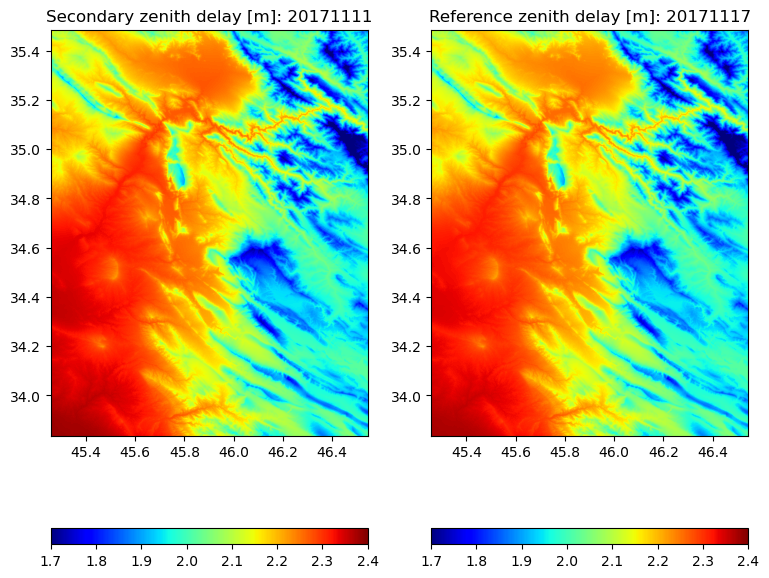

In [34]:
plotdata2('20171111.ztd.geo','20171117.ztd.geo',1,title=['Secondary zenith delay [m]: 20171111','Reference zenith delay [m]: 20171117'],colormap='jet',datamin=1.7, datamax=2.4)

### 3.2 Converting zenith tropopsheric delay to slant phase delay

Next, we will project the zenith delay into the radar slant (radar look direction) by using a simple cosine mapping function of the incidence angle, and at the same time apply the scaling to convert from pseudo-range to phase 
$$\Phi_{\text{slant}}=\frac{-4 \pi}{\lambda* cos(\theta)}*d_{\text{zenith}}$$
The **zenith2slant** function included below takes the geocoded zenith APS file as well as the LOS file as inputs and outputs an ENVI geo-coded slant delay file

In [35]:
 def zenith2slant(losfile,aps_zenith,aps_slant):
    
    # convert all to absolute paths
    aps_zenith = os.path.abspath(aps_zenith)
    aps_slant = os.path.abspath(aps_slant)
    losfile = os.path.abspath(losfile)
    
    # loading the zenith APS file
    ds = gdal.Open(aps_zenith, gdal.GA_ReadOnly)
    zenith = ds.GetRasterBand(1).ReadAsArray()
    proj = ds.GetProjection()
    geotrans = ds.GetGeoTransform()
    ds = None
    
    # loading the incidence angle file
    ds = gdal.Open(losfile, gdal.GA_ReadOnly)
    inc = ds.GetRasterBand(1).ReadAsArray()
    ds = None
    # convert the inc from deg to rad
    inc = inc*np.pi/180
    
    # scaling factor to convert pseudo-range [m] increase to phase delay [rad]
    scaling = -4*np.pi/5.6*100
    
    # projecting the zenith into the slant
    slant = scaling*zenith/np.cos(inc)
    
    # making sure the no-date is propagated
    slant[zenith==0]=0
    slant[inc==0]=0
        
    
    # writing out the file   
    drv = gdal.GetDriverByName('envi').Create(aps_slant, slant.shape[1], slant.shape[0], 1,gdal.GDT_Float32)
    drv.SetGeoTransform(geotrans)
    drv.SetProjection(proj)
    drv.GetRasterBand(1).WriteArray(slant)
    drv = None
    

We will run this function for both SAR acquisitions and plot the results.

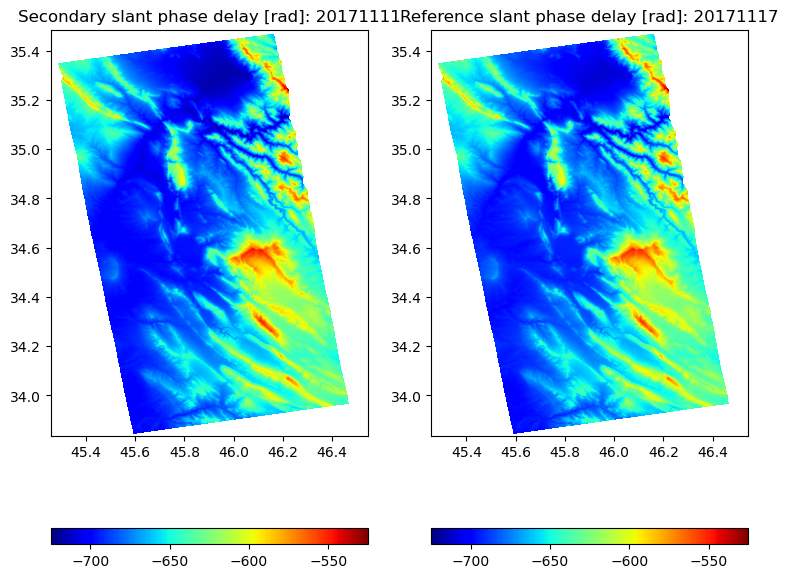

In [36]:
zenith2slant('los.rdr.geo.vrt','20171117.ztd.geo','20171117.aps.geo')
zenith2slant('los.rdr.geo.vrt','20171111.ztd.geo','20171111.aps.geo')
plotdata2('20171111.aps.geo','20171117.aps.geo',1,title=['Secondary slant phase delay [rad]: 20171111','Reference slant phase delay [rad]: 20171117'],colormap='jet',datamin=-725, datamax=-525)

## 4. InSAR Tropospheric phase delay (slant)

Now that we have a tropospheric phase delay estimated for both SAR acquisitions, we can compute the differential delay. Note it is important to apply the same convention as you did when making the interferogram. Below we include the **differential_delay** function which takes a reference and secondary APS files as input as well as an output name.

By investigating the orignal *topsApp.xml* file you can see that the reference was selected as 20171117 and the secondary as 20171111.

$$\Delta \Phi_{\text{slant}}=\Phi_{\text{slant}}^{\text{reference}}- \Phi_{\text{slant}}^{\text{secondary}} $$

In [37]:
def differential_delay(reference_aps,secondary_aps,outname):
    
    # convert all to absolute paths
    reference_aps = os.path.abspath(reference_aps)
    secondary_aps = os.path.abspath(secondary_aps)
    outname = os.path.abspath(outname)
    
    # loading the reference APS file
    ds = gdal.Open(reference_aps, gdal.GA_ReadOnly)
    reference = ds.GetRasterBand(1).ReadAsArray()
    proj = ds.GetProjection()
    geotrans = ds.GetGeoTransform()
    ds = None
    
    # loading the secondary APS file
    ds = gdal.Open(secondary_aps, gdal.GA_ReadOnly)
    secondary = ds.GetRasterBand(1).ReadAsArray()
    ds = None
    
    
    # computing the differential APS
    diffAPS = reference-secondary
    
    # writing out the file 
    drv = gdal.GetDriverByName('envi').Create(outname, diffAPS.shape[1], diffAPS.shape[0], 1,gdal.GDT_Float32)
    drv.SetGeoTransform(geotrans)
    drv.SetProjection(proj)
    drv.GetRasterBand(1).WriteArray(diffAPS)
    drv = None

Below we will execute the **differential_delay** function, and plot the results. From the results you can see that even though the SAR delays looked quite similar there is spatial variation of up to 14 rad. Keeping in mind that 6.28 rad is equivalent to 2.8 cm, we find about 6.2 cm of delay for our intergerogram

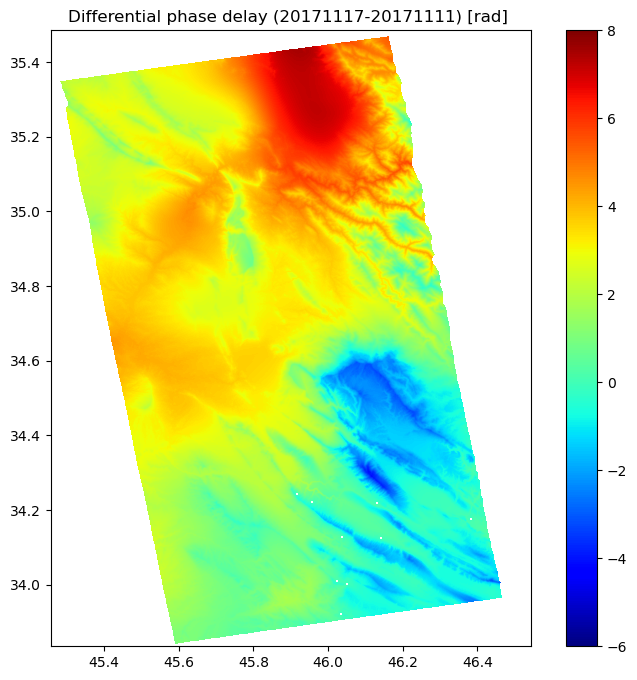

In [38]:
differential_delay('20171117.aps.geo','20171111.aps.geo','20171117_20171111.aps.geo')
plotdata('20171117_20171111.aps.geo',1,title="Differential phase delay (20171117-20171111) [rad] ",colormap='jet',colorbar_orientation="vertical",datamin=-6, datamax=8)

## 5. Applying InSAR Tropospheric correction

As last step we will correct our original interferogram for the estimated tropospheric phase delay. Below we provide the function to do the correction.

In [39]:
def IFG_correction(unw,aps,outname):
    
    # convert all to absolute paths
    unw = os.path.abspath(unw)
    aps = os.path.abspath(aps)
    outname = os.path.abspath(outname)
    
    # loading the UNW file
    ds = gdal.Open(unw, gdal.GA_ReadOnly)
    unwdata_phase = ds.GetRasterBand(2).ReadAsArray()
    unwdata_amplitude = ds.GetRasterBand(1).ReadAsArray()
    proj = ds.GetProjection()
    geotrans = ds.GetGeoTransform()
    ds = None
    
    # loading the APS file
    ds = gdal.Open(aps, gdal.GA_ReadOnly)
    apsdata = ds.GetRasterBand(1).ReadAsArray()
    ds = None
    
    # Correcting the IFG
    unwdata_phase = unwdata_phase-apsdata
    # making sure the no-date is propagated
    unwdata_phase[unwdata_phase==0]=0
    unwdata_phase[apsdata==0]=0 
    
    
    # writing out the file 
    drv = gdal.GetDriverByName('envi').Create(outname, unwdata_phase.shape[1], unwdata_phase.shape[0], 2,gdal.GDT_Float32)
    drv.SetGeoTransform(geotrans)
    drv.SetProjection(proj)
    drv.GetRasterBand(1).WriteArray(unwdata_amplitude)
    drv.GetRasterBand(2).WriteArray(unwdata_phase)
    drv = None
    

Using this function, we will now compute the correction and make a comparison plot before and after correction.

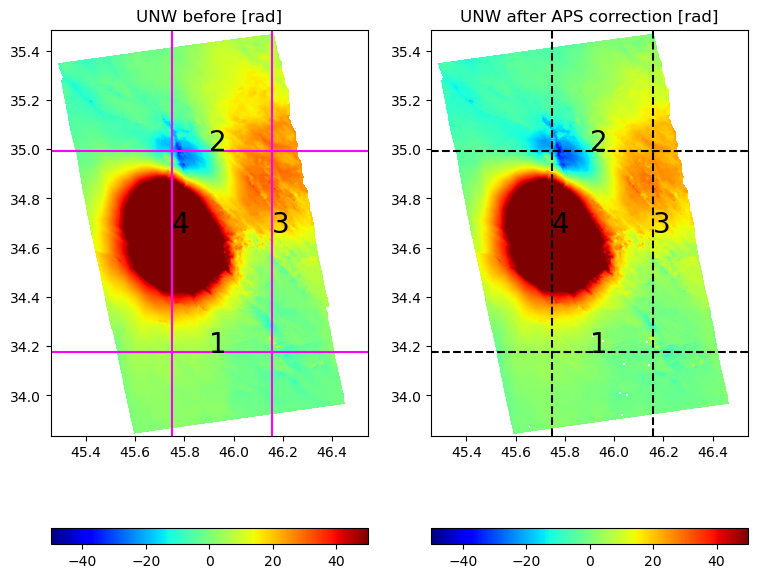

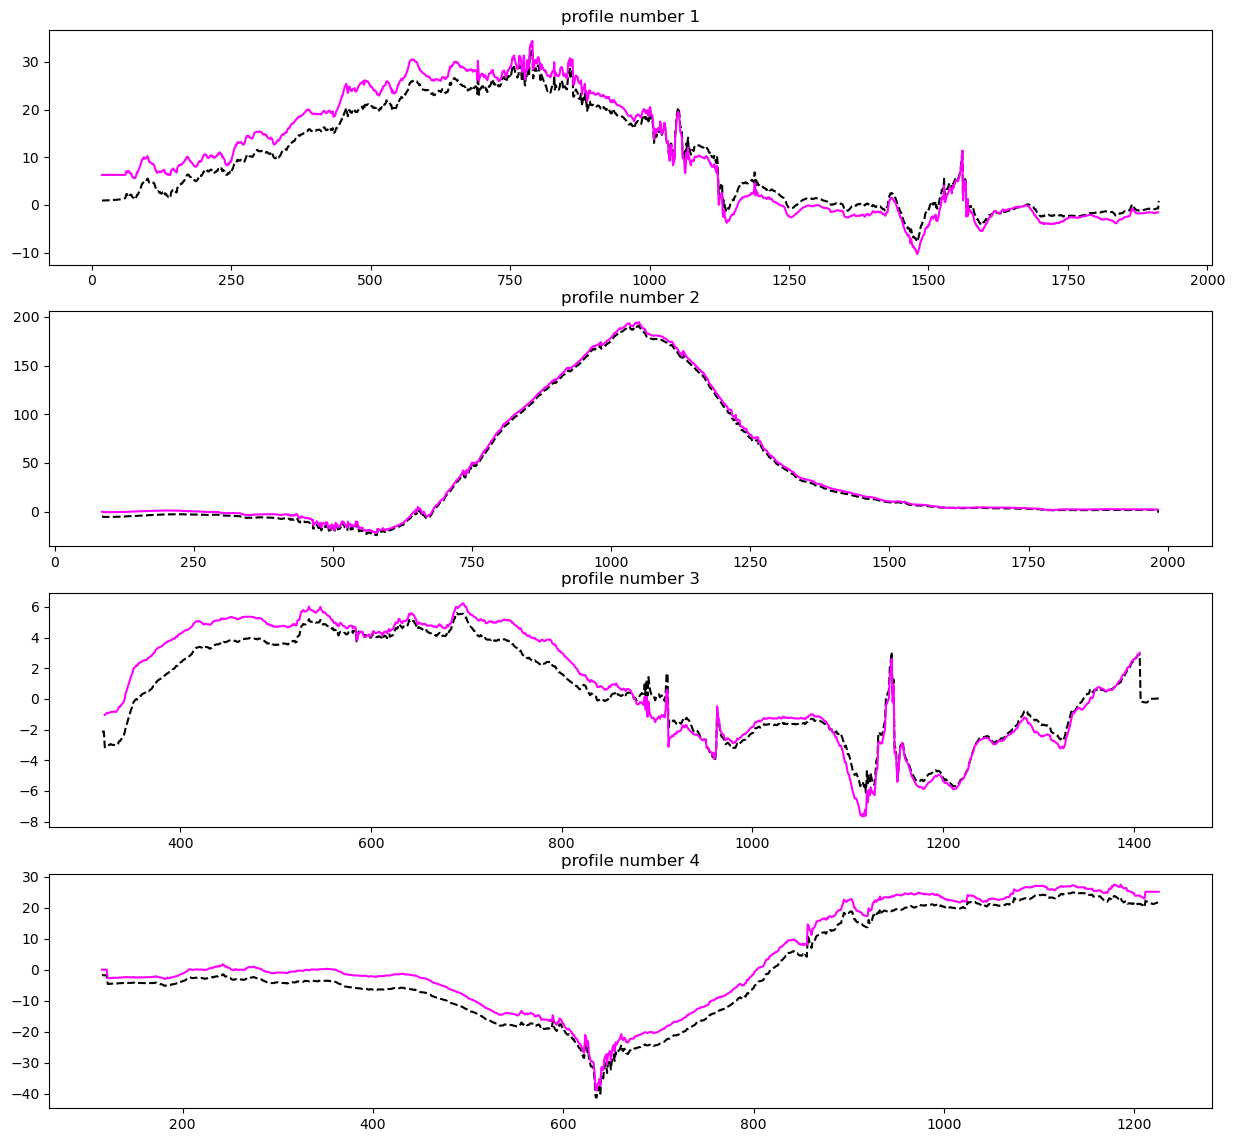

In [40]:
IFG_correction('filt_topophase.unw.geo.vrt','20171117_20171111.aps.geo','filt_topophase_aps.unw.geo')
plotdata2('filt_topophase.unw.geo','filt_topophase_aps.unw.geo',2,title=["UNW before [rad]",'UNW after APS correction [rad]'],colormap='jet',datamin=-50, datamax=50,plot_profile='True')

# Relevant references:
**GACOS**:
- Yu, C., N. T. Penna, and Z. Li (2017), Generation of real-time mode high-resolution water vapor fields from GPS observations, J. Geophys. Res. Atmos., 122, 2008–2025, doi:10.1002/2016JD025753
- Yu, C., Z. Li, and N. T. Penna (2017), Interferometric synthetic aperture radar atmospheric correction using a GPS-based iterative tropospheric decomposition model, Remote Sens. Environ., doi:10.1016/j.rse.2017.10.038.

**Comparison of Tropospheric correction methods**
- D.P.S. Bekaert, R.J. Walters, T.J. Wright, A.J. Hooper, and D.J. Parker (2015) Statistical comparison of InSAR tropospheric correction techniques, Remote Sensing of Environment, doi:10.1016/j.rse.2015.08.035.